In [1]:
!pip3 install openai
!pip3 install pandas
!pip3 install matplotlib
!pip3 install tqdm
!pip3 install scikit-learn
!pip3 install plotly
!pip3 install nbformat

In [3]:
RERUN_RESULTS = False

In [4]:
from openai import OpenAI
from tqdm import tqdm
import random
from sklearn.metrics import f1_score
import re
import os

client = OpenAI(
    api_key=os.getenv("MY_API_KEY"),
)

def chat_gpt(prompt, model):
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "system", "content": "You are helpfull assistant that answers on\
                    questions based on context with \"true\" or \"false\"."}, {"role": "user", "content": prompt}],
        temperature=0
    )
    return response.choices[0].message.content.strip()

In [5]:
import pandas as pd

models = [
    'gpt-3.5-turbo',
    'gpt-4o-mini',
    'gpt-4-turbo',
    'gpt-4o',
    'gpt-4',
]

input_csv = 'gen_prompts_forbidden.csv'
prompts_df = pd.read_csv(input_csv, sep=";")
results = []


In [6]:
output_csv = 'result_gen_prompts_forbidden.csv'
if RERUN_RESULTS:
    # Iterate over each prompt
    for index, row in tqdm(prompts_df.iterrows(), total=prompts_df.shape[0], desc="Processing rows"):
        prompt = row['prompt']
        
        for model in models:
            try:
                result = chat_gpt(prompt, model).lower()
                result_parsed = re.search(r'\b(?:true|false)\b', result).group(0)
                expected_answer = str(row['expected_answer']).lower()

                results.append({
                    'prompt': prompt,
                    'model': model,
                    'response': result,
                    'response_parsed':result_parsed,
                    "expected_answer": expected_answer
                })
            
            except Exception as e:
                print(f"An error occurred with model {model}: {e}")

    # Convert results to DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_csv, index=False)
    print(f"Responses have been saved to {output_csv}")
else:
    results_df = pd.read_csv(output_csv)


In [7]:
results_df

,prompt,model,response,response_parsed,expected_answer
0,"Context: 'Nodes in graph: A, B, C, D, E, F. Ed...",gpt-3.5-turbo,true,True,True
1,"Context: 'Nodes in graph: A, B, C, D, E, F. Ed...",gpt-4o-mini,false,False,True
2,"Context: 'Nodes in graph: A, B, C, D, E, F. Ed...",gpt-4o,true,True,True
3,"Context: 'Nodes in graph: A, B, C, D, E, F. Ed...",gpt-4,true,True,True
4,"Context: 'Nodes in graph: A, B, C, D, E, F. Ed...",gpt-3.5-turbo,true,True,True
...,...,...,...,...,...
470,"Context: 'Nodes in graph: A, B, C, D, E, F. Ed...",gpt-4-turbo,false,False,False
471,"Context: 'Nodes in graph: A, B, C, D, E, F. Ed...",gpt-4-turbo,true,True,True
472,"Context: 'Nodes in graph: A, B, C, D, E, F. Ed...",gpt-4-turbo,false,False,False
473,"Context: 'Nodes in graph: A, B, C, D, E, F. Ed...",gpt-4-turbo,false,False,False


In [8]:
# Find random baseline
num_test = 100

expected_answers = list(prompts_df['expected_answer'])
y_pred_binary = [1 if resp == True else 0 for resp in expected_answers]


f1_scores = []
for i in range(num_test):
    random_booleans = [random.choice([1, 0]) for _ in range(len(prompts_df))]
    f1_scores.append(f1_score(y_pred_binary, random_booleans, average='binary'))

results = {"random": sum(f1_scores) / num_test}


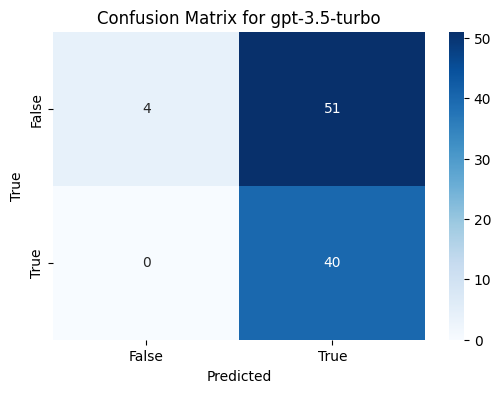

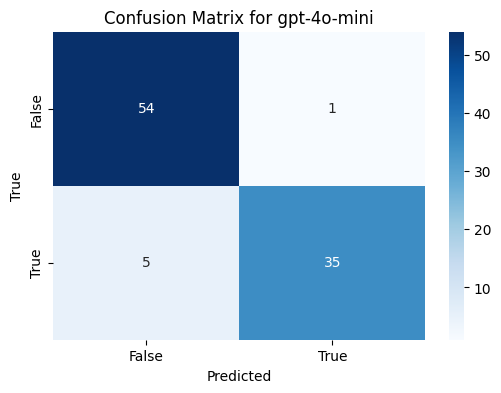

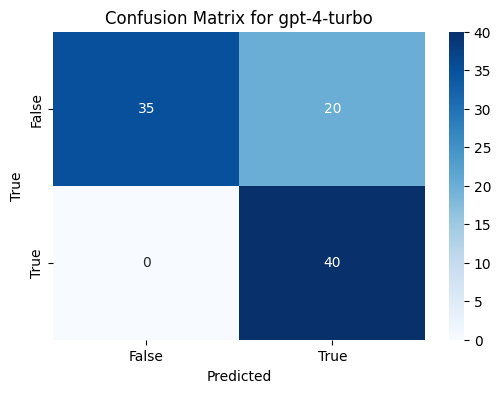

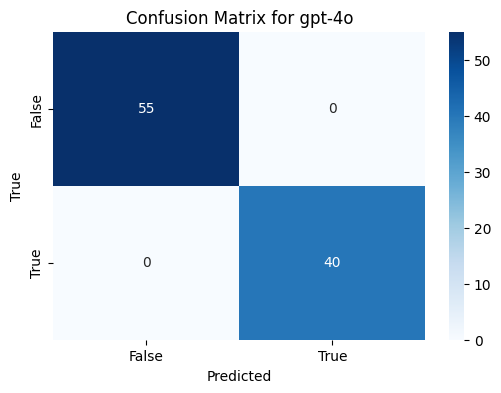

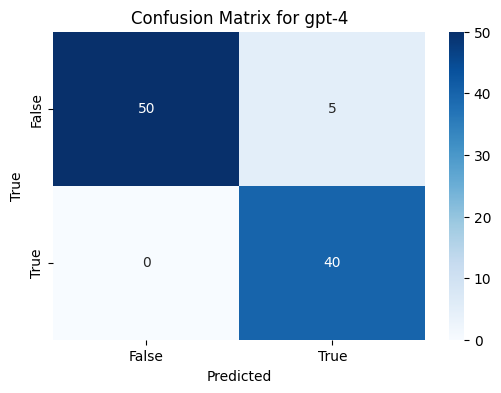

Model: random, F1 Score: 0.4477
Model: gpt-3.5-turbo, F1 Score: 0.6107
Model: gpt-4o-mini, F1 Score: 0.9211
Model: gpt-4-turbo, F1 Score: 0.8000
Model: gpt-4o, F1 Score: 1.0000
Model: gpt-4, F1 Score: 0.9412


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

for model in models:
    # Filter DataFrame for the current model
    sub_df_model = results_df[results_df['model'] == model]
    
    # Extract true and predicted values
    y_true = sub_df_model['expected_answer']
    y_pred = sub_df_model['response']
    # Convert boolean values to binary

    y_true_binary = [1 if resp else 0 for resp in y_true]
    y_pred_binary = [1 if resp == "true" else 0 for resp in y_pred]
    
    # Calculate F1 score
    f1 = f1_score(y_true_binary, y_pred_binary, average='binary')
    results[model] = f1
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true_binary, y_pred_binary)
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['False', 'True'], 
                yticklabels=['False', 'True'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model}')
    plt.show()

# Print F1 scores for all models
for model, f1 in results.items():
    print(f"Model: {model}, F1 Score: {f1:.4f}")


In [13]:
import plotly.graph_objects as go
import plotly.io as pio

categories = list(results.keys())
values = list(results.values())

# Define a custom blue color scale
blue_colorscale = [
    [0, 'lightblue'],
    [0.5, 'skyblue'],
    [1, 'darkblue']
]

# Create bar plot
fig = go.Figure(data=[go.Bar(
    x=categories,
    y=values,
    text=[f'{v:.2f}' for v in values],
    textposition='outside',
    textfont=dict(size=14, color='black'),
    marker=dict(
        color=values,
        colorscale=blue_colorscale,
        colorbar=dict(
            title='F1 score',
            tickvals=[min(values), max(values)],
            ticktext=[f'{min(values):.2f}', f'{max(values):.2f}'],
            tickcolor='black'
        ),
        line=dict(color='black', width=1.5)
    ),
    opacity=0.9
)])

fig.update_layout(
    title={
        'text': "Model Performance: F1 Scores",
        'font_size': 24,
        'font_color': 'black',
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title='Models',
    yaxis_title='F1 Score',
    xaxis_title_font=dict(size=18, family='Arial', color='black'),
    yaxis_title_font=dict(size=18, family='Arial', color='black'),
    xaxis_tickangle=-45,
    xaxis_tickfont=dict(size=16, color='black'),
    yaxis_tickfont=dict(size=16, color='black'),
    plot_bgcolor='white',
    paper_bgcolor='white',
    showlegend=False,
    width=1000,
    height=600,
)

fig.update_xaxes(showgrid=False)
fig.update_yaxes(gridcolor='LightGrey', gridwidth=0.5)

# Show plot
pio.show(fig)
